# Import all Dependecies

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
from keras.applications.vgg16 import VGG16
import os

# Set all the Constants

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

# Import data into tensorflow dataset object

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage2",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 4627 files belonging to 5 classes.


In [4]:
class_names= dataset.class_names
class_names

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy']

In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())


(32, 256, 256, 3)
[1 2 2 3 3 0 3 1 3 2 0 3 1 3 1 0 3 0 3 1 3 3 0 3 3 1 1 1 0 1 2 0]


# SAMPLE

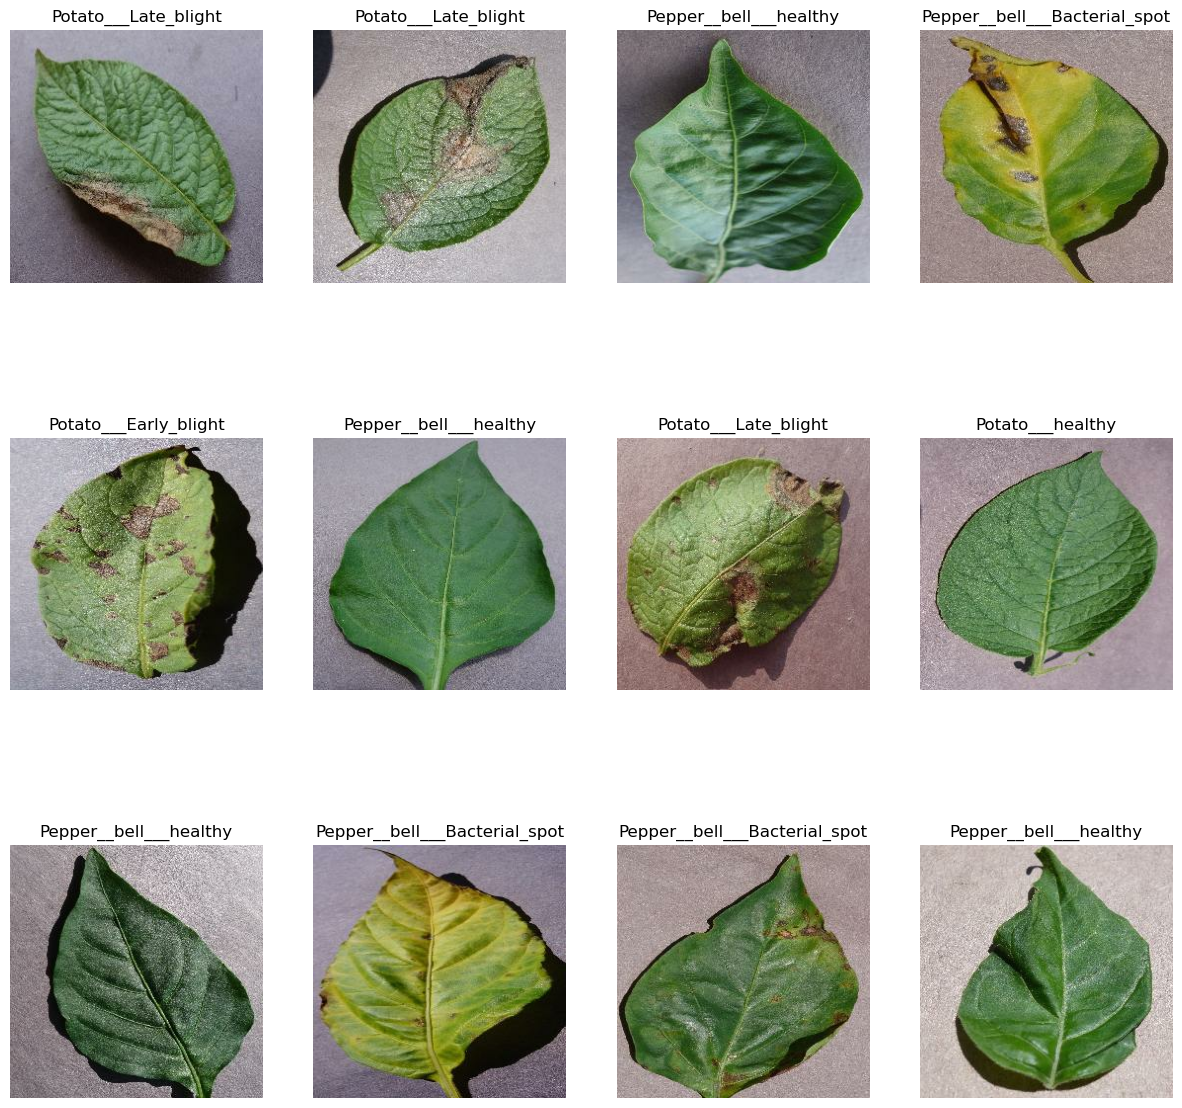

In [8]:
plt.figure(figsize=(15, 15))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

# SPLIT DATASET

In [9]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [25]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [11]:
len(train_ds),len(val_ds),len(test_ds)

(116, 14, 15)

# Cache, Shuffle, and Prefetch the Dataset

In [26]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Creating a Layer for Resizing and Normalization

In [13]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1.0/255),
])

# Data Augmentation

In [14]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])


# Applying Data Augmentation to Train Dataset

In [15]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

# Model Architecture

In [16]:
save_dir = '/Users/nasifsadiq/Go to files/BracU/Semester 12/CSE470/Project/temp/checkpoints2'
if not os.path.exists(save_dir):
   os.makedirs(save_dir)

checkpoint_filepath = os.path.join(save_dir, "checkpoint-{epoch:02d}-{val_loss:.2f}.h5")

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
filepath=checkpoint_filepath,
save_weights_only=False,
monitor='val_accuracy',
mode='max',
save_best_only=True)

In [17]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)
base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
model = models.Sequential()
for layer in base_model.layers:
    layer.trainable=False
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
#model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(n_classes, activation = 'softmax'))

model.build(input_shape=input_shape)

In [18]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [19]:
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [23]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=60,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/60
116/116 [==============================] - 53s 446ms/step - loss: 1.2578 - accuracy: 0.6437 - val_loss: 0.5372 - val_accuracy: 0.8207
Epoch 2/60
116/116 [==============================] - 51s 440ms/step - loss: 0.3418 - accuracy: 0.8846 - val_loss: 0.3765 - val_accuracy: 0.8621
Epoch 3/60
116/116 [==============================] - 51s 437ms/step - loss: 0.2448 - accuracy: 0.9140 - val_loss: 0.2559 - val_accuracy: 0.9103
Epoch 4/60
116/116 [==============================] - 51s 439ms/step - loss: 0.2076 - accuracy: 0.9286 - val_loss: 0.2322 - val_accuracy: 0.9080
Epoch 5/60
116/116 [==============================] - 51s 436ms/step - loss: 0.1788 - accuracy: 0.9348 - val_loss: 0.1736 - val_accuracy: 0.9333
Epoch 6/60
116/116 [==============================] - 49s 425ms/step - loss: 0.1124 - accuracy: 0.9611 - val_loss: 0.1556 - val_accuracy: 0.9402
Epoch 9/60
116/116 [==============================] - 50s 428ms/step - loss: 0.1220 - accuracy: 0.9586 - val_loss: 0.1353 - val_ac

# Load Model

In [20]:
new_model=tf.keras.models.load_model("/Users/nasifsadiq/Go to files/BracU/Semester 12/CSE470/Project/temp/checkpoints2/checkpoint-35-0.06.h5")

In [27]:
scores = new_model.evaluate(test_ds)

15/15 [==============================] - 6s 283ms/step - loss: 0.0739 - accuracy: 0.9729
